## <h1 align="center"> DS510: AI/ML - Lab</h1>
<h1 align="center">⛳ Project - Phase 2</h1>
<h1 align="center"> Team - KERAS</h1>

---

# Traffic-Violation-Detection

## Installing Required Libraries
The following commands install the necessary libraries for the project:
- `pytesseract`: For Optical Character Recognition (OCR) to extract text from images.
- `easyocr`: Another library for OCR that supports multiple languages.

In [1]:
!pip install pytesseract

In [2]:
!pip install easyocr

In [3]:
!pip install gdown

## Importing Libraries
We import several libraries used for image processing, OCR, database connection, and handling warnings.

In [4]:
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import matplotlib.pyplot as plt
import cv2
import os
import requests
import pytesseract
import easyocr
import re
import gdown
from PIL import Image
from collections import deque
from mysql.connector import Error

### `detect_traffic_light_color` Function
This function takes an image and a rectangle (`rect`) as input and returns the detected traffic light color in the region of interest.

1. Extracts the region of interest (ROI) from the image using the rectangle.
2. Converts the ROI to the HSV color space to make color detection easier.
3. Defines HSV ranges for red and yellow traffic light colors.
4. Creates binary masks to identify whether red or yellow is present in the ROI.
5. Based on the presence of a color in the masks, it overlays a message on the image to indicate the traffic light's status: "Stop" (Red), "Caution" (Yellow), or "Go" (Green).
6. The modified image and the detected traffic light color are returned.

In [5]:
def detect_traffic_light_color(image, rect):
    # Extract rectangle dimensions
    x, y, w, h = rect
    # Extract region of interest (ROI) from the image based on the rectangle
    roi = image[y:y+h, x:x+w]
    
    # Convert ROI to HSV color space
    hsv = cv2.cvtColor(roi, cv2.COLOR_BGR2HSV)

    # Define HSV range for red color
    red_lower = np.array([0, 120, 70])
    red_upper = np.array([10, 255, 255])
    
    # Define HSV range for yellow color
    yellow_lower = np.array([20, 100, 100])
    yellow_upper = np.array([30, 255, 255])

    # Create binary masks for detecting red and yellow in the ROI
    red_mask = cv2.inRange(hsv, red_lower, red_upper)
    yellow_mask = cv2.inRange(hsv, yellow_lower, yellow_upper)
    
    # Font details for overlaying text on the image
    font = cv2.FONT_HERSHEY_TRIPLEX
    font_scale = 1  
    font_thickness = 2  
    
    # Check which color is present based on the masks
    if cv2.countNonZero(red_mask) > 0:
        text_color = (0, 0, 255)
        message = "Detected Signal Status: Stop"
        color = 'red'
    elif cv2.countNonZero(yellow_mask) > 0:
        text_color = (0, 255, 255)
        message = "Detected Signal Status: Caution"
        color = 'yellow'
    else:
        text_color = (0, 255, 0)
        message = "Detected Signal Status: Go"
        color = 'green'
        
    # Overlay the detected traffic light status on the main image
    cv2.putText(image, message, (15, 70), font, font_scale+0.5, text_color, font_thickness+1, cv2.LINE_AA)
    # Add a separator line
    cv2.putText(image, 34*'-', (10, 115), font, font_scale, (255,255,255), font_thickness, cv2.LINE_AA)
    
    # Return the modified image and detected color
    return image, color

### `LineDetector` Class
This class detects white lines on the road in video frames and averages the detected line's position over multiple frames to smooth out any noise.

1. **Initialization**: It uses two queues (`deque`) to store the y-coordinates of the start and end points of the detected line for a specified number of frames (`num_frames_avg`).
2. **detect_white_line**: This method detects white lines based on a region of interest (ROI) defined by specific slopes and intercepts.
    - It applies edge detection and then uses the Hough Line Transform to detect lines.
    - It calculates the average y-coordinate values for the start and end points of the line across frames.
    - The detected line is drawn on the original frame, and the method returns the modified frame and a mask highlighting the detected line area.

In [6]:
class LineDetector:
    def __init__(self, num_frames_avg=10):
        # Initialize two deque queues to hold y-coordinate values across frames
        self.y_start_queue = deque(maxlen=num_frames_avg)
        self.y_end_queue = deque(maxlen=num_frames_avg)

    
    def detect_white_line(self, frame, color, 
                          slope1=0.03, intercept1=920, slope2=0.03, intercept2=770, slope3=-0.8, intercept3=2420):
        
        # Function to map color names to BGR values
        def get_color_code(color_name):
            color_codes = {
                'red': (0, 0, 255),
                'green': (0, 255, 0),
                'yellow': (0, 255, 255)
                 }
            return color_codes.get(color_name.lower())

        frame_org = frame.copy()
        
        # Line equations for defining region of interest (ROI)
        def line1(x): return slope1 * x + intercept1
        def line2(x): return slope2 * x + intercept2
        def line3(x): return slope3 * x + intercept3

        height, width, _ = frame.shape
        
        # Create a mask to spotlight the line's desired area
        mask1 = frame.copy()
        # Set pixels below the first line to black in mask1
        for x in range(width):
            y_line = line1(x)
            mask1[int(y_line):, x] = 0

        mask2 = mask1.copy()
        # Set pixels above the second line to black in mask2
        for x in range(width):
            y_line = line2(x)
            mask2[:int(y_line), x] = 0

        mask3 = mask2.copy()
        # Set pixels to the left of the third line to black in mask3 (final mask)
        for y in range(height):
            x_line = line3(y)
            mask3[y, :int(x_line)] = 0

        # Convert the mask to grayscale
        gray = cv2.cvtColor(mask3, cv2.COLOR_BGR2GRAY)

        # Apply a Gaussian filter to the ROI
        blurred_gray = cv2.GaussianBlur(gray, (7, 7), 0)

        # Apply CLAHE to equalize the histogram
        clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
        gray_clahe = clahe.apply(blurred_gray)

        # Perform edge detection
        edges = cv2.Canny(gray, 30, 100)

        # Perform a dilation and erosion to close gaps in between object edges
        dilated_edges = cv2.dilate(edges, None, iterations=1)
        edges = cv2.erode(dilated_edges, None, iterations=1)

        # Perform Hough Line Transform
        lines = cv2.HoughLinesP(edges, 1, np.pi/180, 100, minLineLength=160, maxLineGap=5)

        # Calculate x coordinates for the start and end of the line
        x_start = 0
        x_end = width - 1

        if lines is not None:
            for line in lines:
                x1, y1, x2, y2 = line[0]

                # Calculate line parameters
                slope = (y2 - y1) / (x2 - x1 + np.finfo(float).eps)  # Add a small number to avoid division by zero
                intercept = y1 - slope * x1

                # Calculate corresponding y coordinates
                y_start = int(slope * x_start + intercept)
                y_end = int(slope * x_end + intercept)

                # Add the y_start and y_end values to the queues
                self.y_start_queue.append(y_start)
                self.y_end_queue.append(y_end)

        # Compute the average y_start and y_end values
        avg_y_start = int(sum(self.y_start_queue) / len(self.y_start_queue)) if self.y_start_queue else 0
        avg_y_end = int(sum(self.y_end_queue) / len(self.y_end_queue)) if self.y_end_queue else 0

        
        # Draw the line
        line_start_ratio=0.32
        x_start_adj = x_start + int(line_start_ratio * (x_end - x_start))  # Adjusted x_start
        avg_y_start_adj = avg_y_start + int(line_start_ratio * (avg_y_end - avg_y_start))  # Adjusted avg_y_start

        # Create a mask with the same size as the frame and all zeros (black)
        mask = np.zeros_like(frame)

        # Draw the line on the mask
        cv2.line(mask, (x_start_adj, avg_y_start_adj), (x_end, avg_y_end), (255, 255, 255), 4)

        # Determine which color channel(s) to change based on the color argument
        color_code = get_color_code(color)
        if color_code == (0, 255, 0):  # Green
            channel_indices = [1]
        elif color_code == (0, 0, 255):  # Red
            channel_indices = [2]
        elif color_code == (0, 255, 255):  # Yellow
            # Yellow in BGR is a combination of green and red channels.
            # Here we modify both green and red channels.
            channel_indices = [1, 2]
        else:
            raise ValueError('Unsupported color')

        # Change the specified color channels of the frame where the mask is white
        for channel_index in channel_indices:
            frame[mask[:,:,channel_index] == 255, channel_index] = 255
                
                
        # Calculate slope and intercept for the average green line
        slope_avg = (avg_y_end - avg_y_start) / (x_end - x_start + np.finfo(float).eps)
        intercept_avg = avg_y_start - slope_avg * x_start

        # Create a mask with the pixels above the green line set to black
        mask_line = np.copy(frame_org)
        for x in range(width):
            y_line = slope_avg * x + intercept_avg - 35
            mask_line[:int(y_line), x] = 0  # set pixels above the line to black

        return frame, mask_line

### `extract_license_plate` function

This function processes a given video frame to detect and extract license plates. It uses a combination of image preprocessing, histogram equalization, and Haar Cascade detection. The function returns the original frame with detected license plates highlighted and a list of cropped license plate images.


1. **Convert to Grayscale:**
   - `gray = cv2.cvtColor(mask_line, cv2.COLOR_BGR2GRAY)`
   - License plate detection using Haar Cascades is typically performed on grayscale images, so the input frame is converted to grayscale to reduce computational complexity.

2. **Histogram Equalization with CLAHE:**
   - `clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))`
   - CLAHE (Contrast Limited Adaptive Histogram Equalization) is applied to enhance contrast in localized areas, which helps in better detection of the license plate by making the plate stand out from the background.

3. **Erosion for Noise Reduction:**
   - `gray = cv2.erode(gray, kernel, iterations=1)`
   - A small 2x2 kernel is used for erosion, removing small noise that might interfere with license plate detection.

4. **Bounding Box Calculation:**
   - `x, y, w, h = cv2.boundingRect(non_black_points)`
   - The function finds non-black pixels (the area of interest) and calculates the bounding rectangle that encloses them, focusing on the region where the license plate is expected.

5. **Exclude 30% of Width:**
   - `w = int(w * 0.7)`
   - The function reduces the width of the bounding box by 30% to avoid including unnecessary parts of the image, narrowing the focus to the license plate area.

6. **Cropping the Image:**
   - `cropped_gray = gray[y:y+h, x:x+w]`
   - The image is cropped to the bounding box to focus on the relevant part where the license plate is expected to be.

7. **License Plate Detection:**
   - `license_plates = license_plate_cascade.detectMultiScale(cropped_gray, ...)`
   - The cropped image is fed into a pre-trained Haar Cascade for license plate detection. The function returns a list of rectangles, each representing a detected license plate.

8. **Draw Bounding Boxes:**
   - `cv2.rectangle(frame, (x_plate + x, y_plate + y), ...)`
   - A green rectangle is drawn around each detected license plate on the original frame to visually highlight the location of the license plate.

9. **Extract License Plates:**
   - `license_plate_image = cropped_gray[y_plate:y_plate+h_plate, x_plate:x_plate+w_plate]`
   - The detected license plates are cropped from the image and stored in the `license_plate_images` list.

10. **Return Values:**
    - The function returns two values:
      1. `frame`: The original frame with rectangles drawn around detected license plates.
      2. `license_plate_images`: A list of cropped images of detected license plates.


In [7]:
def extract_license_plate(frame, mask_line):    
    # Convert the image to grayscale (Haar cascades are typically trained on grayscale images)
    gray = cv2.cvtColor(mask_line, cv2.COLOR_BGR2GRAY)
    
    # Apply CLAHE to equalize the histogram
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
    gray = clahe.apply(gray)
    
    # Erode the image using a 2x2 kernel to remove noise
    kernel = np.ones((2, 2), np.uint8)
    gray = cv2.erode(gray, kernel, iterations=1)

    # Find the bounding box of non-black pixels
    non_black_points = cv2.findNonZero(gray)
    x, y, w, h = cv2.boundingRect(non_black_points)

    # Calculate the new width of the bounding box, excluding 30% on the right side
    w = int(w * 0.7)

    # Crop the image to the bounding box
    cropped_gray = gray[y:y+h, x:x+w]

    # Detect license plates in the image (this returns a list of rectangles)
    license_plates = license_plate_cascade.detectMultiScale(cropped_gray, scaleFactor=1.07, minNeighbors=15, minSize=(20, 20))

    # List to hold cropped license plate images
    license_plate_images = []

    # Loop over the license plates
    for (x_plate, y_plate, w_plate, h_plate) in license_plates:
        # Draw a rectangle around the license plate in the original frame (here you need the original coordinates)
        cv2.rectangle(frame, (x_plate + x, y_plate + y), (x_plate + x + w_plate, y_plate + y + h_plate), (0, 255, 0), 3)
    
        # Crop the license plate and append it to the list (here x_plate and y_plate are relative to cropped_gray)
        license_plate_image = cropped_gray[y_plate:y_plate+h_plate, x_plate:x_plate+w_plate]
        license_plate_images.append(license_plate_image)

    return frame, license_plate_images

### `apply_ocr_to_image` function

This function takes an image of a license plate and applies Optical Character Recognition (OCR) using Tesseract to extract the text (license plate number). It preprocesses the image before performing OCR to improve accuracy.


1. **Thresholding the Image:**
   - `_, img = cv2.threshold(license_plate_image, 120, 255, cv2.THRESH_BINARY)`
   - This step converts the grayscale license plate image into a binary (black-and-white) image. Thresholding is a common preprocessing step in OCR to enhance the contrast between the text and the background. Pixels with values above 120 are set to white (255), and those below are set to black (0). This simplifies the text extraction process for Tesseract.

2. **Converting OpenCV Image to PIL Format:**
   - `pil_img = Image.fromarray(img)`
   - Tesseract's `pytesseract` library works with PIL (Python Imaging Library) images, whereas OpenCV works with NumPy arrays. This conversion from the OpenCV `license_plate_image` (NumPy array) to a PIL Image object is necessary to interface with `pytesseract`.

3. **Applying OCR using Pytesseract:**
   - `full_text = pytesseract.image_to_string(pil_img, config='--psm 6')`
   - The `pytesseract.image_to_string` function is used to extract text from the image. 
   - The parameter `config='--psm 6'` specifies the Page Segmentation Mode (PSM), which tells Tesseract how to segment the image. Mode 6 assumes a block of text where each line may be a single text entity, making it suitable for structured text like license plates.

4. **Cleaning the Extracted Text:**
   - `return full_text.strip()`
   - The extracted text may contain leading or trailing white spaces. The `strip()` method removes any extra white spaces at the beginning and end, returning the cleaned license plate number.

In [8]:
def apply_ocr_to_image(license_plate_image):    
    # Threshold the image
    _, img = cv2.threshold(license_plate_image, 120, 255, cv2.THRESH_BINARY)

    # Convert OpenCV image format to PIL Image format for pytesseract
    pil_img = Image.fromarray(img)

    # Use pytesseract to extract text from the image
    full_text = pytesseract.image_to_string(pil_img, config='--psm 6')

    return full_text.strip()  # Removing any extra white spaces from the ends

# `draw_penalized_text` function
- to overlay a list of fined license plates onto a given frame. This is typically used in applications related to traffic enforcement or monitoring.


In [9]:
def draw_penalized_text(frame):
    # Set font, scale, thickness, and color
    font = cv2.FONT_HERSHEY_TRIPLEX
    font_scale = 1  
    font_thickness = 2
    color = (255, 255, 255)  # White color
    
    # Initial position for Y-coordinate
    y_pos = 180
    
    # Put title on the frame
    cv2.putText(frame, 'Fined license plates:', (25, y_pos), font, font_scale, color, font_thickness)
    
    # Update Y-coordinate position
    y_pos += 80

    # Loop through all fined license plates
    for text in penalized_texts:
        # Add fined license plate text on the frame
        cv2.putText(frame, '->  '+text, (40, y_pos), font, font_scale, color, font_thickness)
        
        # Update Y-coordinate for next license plate
        y_pos += 60

In [10]:
import cv2
import re
import matplotlib.pyplot as plt
import gdown
import os

def main():
    # List to store penalized license plates
    penalized_texts = []

    # URL for the Google Drive file
    url = 'https://drive.google.com/uc?id=1_Enu0ZBM4bvB-AfnUwoMppw57TgdBhet'
    output = 'traffic_video.mp4'

    # Download the video file from Google Drive
    gdown.download(url, output, quiet=False)

    # Open the video file
    vid = cv2.VideoCapture(output)
    
    # Create detector object
    detector = LineDetector()

    # Loop through each frame in the video
    while True:
        # Read frame
        ret, frame = vid.read()
        
        # Break if frame is not returned
        if not ret:
            break

        # Assuming rect is the rectangle where the traffic light is located
        rect = (1700, 40, 100, 250) 
        
        # Detect traffic light color
        frame, color = detect_traffic_light_color(frame, rect)
        
        # Detect white line
        frame, mask_line = detector.detect_white_line(frame, color)
        
        # Process the frame if the light is red
        if color == 'red':
            # Extract license plate
            frame, license_plate_images = extract_license_plate(frame, mask_line)
            
            # Process each detected license plate
            for license_plate_image in license_plate_images:
                # Apply OCR to the license plate image
                text = apply_ocr_to_image(license_plate_image)
                
                # Add the detected license plate to the list if it matches the pattern and is not already in the list
                if text is not None and re.match("^[A-Z]{2}\s[0-9]{3,4}$", text) and text not in penalized_texts:
                    penalized_texts.append(text)
                    print(f"\nFined license plate: {text}")

                    # Plot the license plate image
                    plt.figure()
                    plt.imshow(license_plate_image, cmap='gray')
                    plt.axis('off')
                    plt.show()
        
        # Draw the penalized text onto the frame if there is any
        if penalized_texts:
            draw_penalized_text(frame)

        # Display the frame 
        cv2.imshow('frame', frame)

        # Break if ESC key is pressed
        if cv2.waitKey(1) == 27:
            break

    # Release the video
    vid.release()
    
    # Close all OpenCV windows
    cv2.destroyAllWindows()

    # Print all the detected violations
    print("\nAll violations:")
    for text in penalized_texts:
        print(f"- {text}")

`haarcascade_russian_plate_number.xml`- This model, tailor-made for detecting license plates, is paramount for identifying license plates in our video frames.

In [11]:
import cv2
import gdown

# Download the trained Haar Cascade from Google Drive
url = "https://drive.google.com/uc?id=1rg06EeyQrOqPylX_vwcfFzPlY_PLYmzD"
output = 'haarcascade_russian_plate_number.xml'

# Download the Haar Cascade XML file
gdown.download(url, output, quiet=False)

# Load the trained Haar Cascade
license_plate_cascade = cv2.CascadeClassifier(output)

# Create a list to store unique penalized license plate texts
penalized_texts = []

# Optional: Print a message to confirm successful loading
if license_plate_cascade.empty():
    print("Error loading Haar Cascade!")
else:
    print("Haar Cascade loaded successfully.")


Downloading...
From (original): https://drive.google.com/uc?id=1rg06EeyQrOqPylX_vwcfFzPlY_PLYmzD
From (redirected): https://drive.google.com/uc?id=1rg06EeyQrOqPylX_vwcfFzPlY_PLYmzD&confirm=t&uuid=21646572-27f6-4494-9921-aed40363a12c
To: /Users/shivam/Desktop/aiml/haarcascade_russian_plate_number.xml
100%|██████████| 75.5k/75.5k [00:00<00:00, 445kB/s]


Haar Cascade loaded successfully.


Downloading...
From: https://drive.google.com/uc?id=1_Enu0ZBM4bvB-AfnUwoMppw57TgdBhet
To: /Users/shivam/Desktop/aiml/traffic_video.mp4
100%|██████████| 37.7M/37.7M [00:01<00:00, 20.0MB/s]
2024-10-30 09:17:18.941 python[27616:1803136] +[IMKClient subclass]: chose IMKClient_Legacy
2024-10-30 09:17:18.941 python[27616:1803136] +[IMKInputSession subclass]: chose IMKInputSession_Legacy



Fined license plate: YB 6433


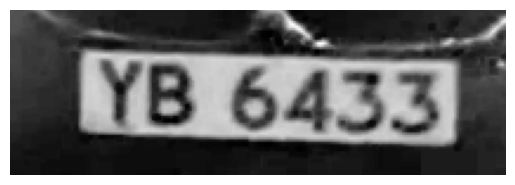


Fined license plate: AW 773


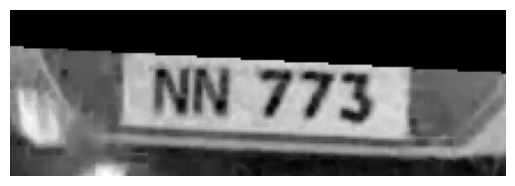


All violations:
- YB 6433
- AW 773


In [12]:
if __name__ == "__main__":
    main()

---